In [17]:
from six.moves import xrange

import sys, os
sys.path.insert(0, '..')
import time

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from lib.datasets.cifar_10 import Cifar10
from lib.segmentation.feature_extraction import form_feature_extraction, NUM_FORM_FEATURES
from lib.segmentation.feature_extraction import feature_extraction, NUM_FEATURES
from lib.segmentation.algorithm import slic, felzenszwalb

%matplotlib inline

data = Cifar10('/tmp/cifar_10')

# Form Feature Selection

In [18]:
NUM_EXAMPLES = 200

features_selected = np.arange(0, NUM_FORM_FEATURES)

images = data.test._data[:NUM_EXAMPLES]
labels_one_hot = data.test._labels[:NUM_EXAMPLES]

features = np.zeros((0, NUM_FORM_FEATURES), np.float32)
computed_features = np.zeros((0, NUM_FEATURES), np.float32)
labels = np.zeros((0), np.uint8)

t_segmentation = 0
t_features = 0
t_computed_features = 0

for i in xrange(NUM_EXAMPLES):
    image = np.reshape(images[i], (32, 32, 3))
    label = labels_one_hot[i]
    label = np.where(label == 1)[0][0]
    
    t_start = time.process_time()
    segmentation = slic(image, num_segments=100, compactness=5, max_iterations=10, sigma=0)
    # segmentation = felzenszwalb(image, scale=10, min_size=2, sigma=2)
    
    t_segmentation += time.process_time() - t_start
    
    t_start = time.process_time()
    # Form features are scaled to [0, 1] for each image.
    f_1 = form_feature_extraction(segmentation, image)
    t_features += time.process_time() - t_start
    
    t_start = time.process_time()
    f_2 = feature_extraction(segmentation, image)
    t_computed_features += time.process_time() - t_start

    features = np.concatenate((features, f_1), axis=0)
    computed_features = np.concatenate((computed_features, f_2), axis=0)
    
    label = np.zeros((f_1.shape[0]), np.uint8) + label
    labels = np.concatenate((labels, label))
    
print('Segmentation duration: {:.5f}s'.format(t_segmentation))
print('Feature extraction duration: {:.5f}s'.format(t_features))
print('Computed Feature extraction duration: {:.5f}s'.format(t_computed_features))
print('Number of segments collected:', features.shape[0])
print('Number of features collected:', features.shape[1])

Segmentation duration: 0.43062s
Feature extraction duration: 23.34360s
Computed Feature extraction duration: 3.70414s
Number of segments collected: 17638
Number of features collected: 77


## Plot mean, variance, standard deviation and Pearson correlation

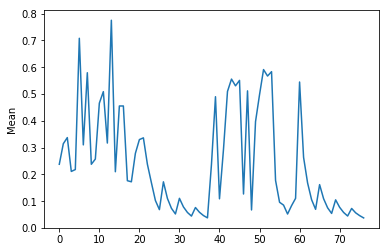

In [19]:
plt.plot(np.mean(features, axis=0))
plt.ylabel('Mean')
plt.show()

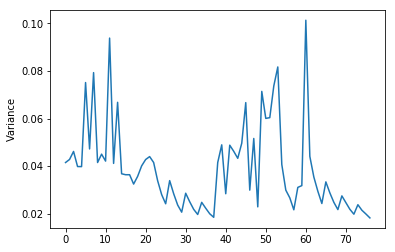

In [20]:
plt.plot(np.var(features, axis=0))
plt.ylabel('Variance')
plt.show()

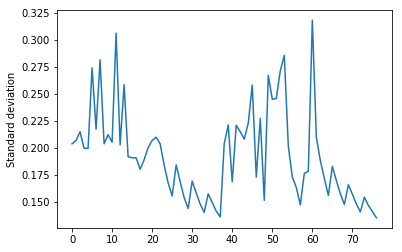

In [21]:
plt.plot(np.std(features, axis=0))
plt.ylabel('Standard deviation')
plt.show()

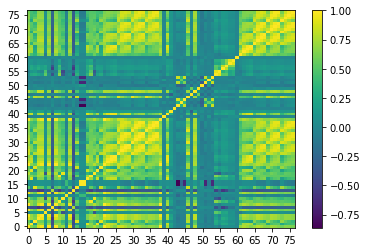

In [22]:
corrcoef = np.corrcoef(features, rowvar=False)

plt.pcolor(corrcoef)
plt.colorbar()
plt.yticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.xticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.show()

## Run PCA

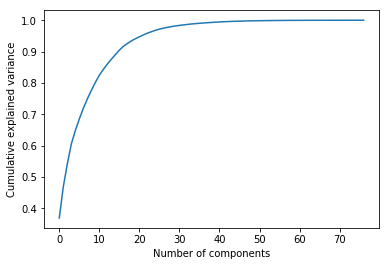

In [23]:
pca = PCA()
pca.fit(features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

## Removing features with low variance

In [24]:
from sklearn.feature_selection import VarianceThreshold

THRESHOLD = 0.03
sel = VarianceThreshold(threshold=THRESHOLD)
sel.fit(features)

print('Number of features before removing:', features.shape[1])
features = sel.transform(features)
print('Number of features after removing:', features.shape[1])

features_selected = features_selected[np.where(sel.get_support())[0]]
print('Features selected:', features_selected)

Number of features before removing: 77
Number of features after removing: 45
Features selected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 26
 38 39 41 42 43 44 45 47 49 50 51 52 53 54 58 59 60 61 62 65]


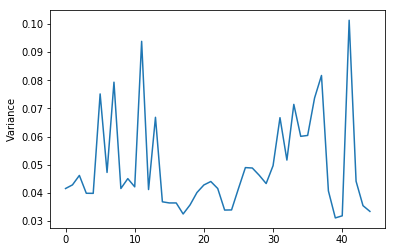

In [25]:
# Verify result.
plt.plot(np.var(features, axis=0))
plt.ylabel('Variance')
plt.show()

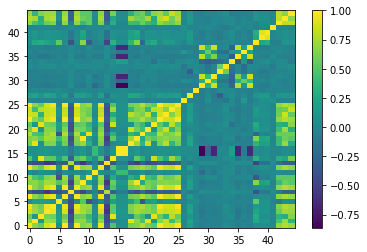

In [26]:
# Update Pearson correlation.
corrcoef = np.corrcoef(features, rowvar=False)

plt.pcolor(corrcoef)
plt.colorbar()
NUM_FORM_FEATURES = features.shape[1]
plt.yticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.xticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.show()

## Univariate feature selection

Select the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.

In [27]:
from sklearn.feature_selection import SelectKBest, chi2

K = 20
sel = SelectKBest(chi2, k=K)
sel.fit(features, labels)

print('Number of features before removing:', features.shape[1])
features = sel.transform(features)
print('Number of features after removing:', features.shape[1])

features_selected = features_selected[np.where(sel.get_support())[0]]
print('Features selected:', features_selected)

Number of features before removing: 45
Number of features after removing: 20
Features selected: [ 7  9 15 16 18 39 41 42 43 44 45 47 49 50 51 52 53 58 59 60]


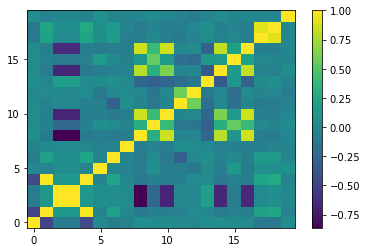

In [28]:
corrcoef = np.corrcoef(features, rowvar=False)
plt.pcolor(corrcoef)
plt.colorbar()
NUM_FORM_FEATURES = features.shape[1]
plt.yticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.xticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.show()

## Recursive feature elimination (RFE)

Recursive feature elimination selects features recursively considerung smaller and smaller sets of features.

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

K = 13
model = LogisticRegression()
rfe = RFE(model, K)
rfe = rfe.fit(features, labels)

print('Number of features before removing:', features.shape[1])
features = rfe.transform(features)
print('Number of features after removing:', features.shape[1])

features_selected = features_selected[np.where(rfe.get_support())[0]]
print('Features selected:', features_selected)

Number of features before removing: 20
Number of features after removing: 13
Features selected: [ 9 16 18 41 42 43 44 45 51 52 53 58 59]


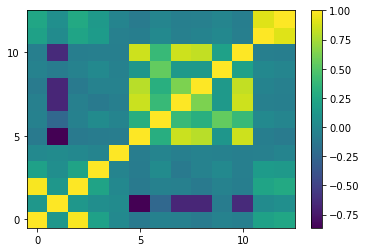

In [30]:
corrcoef = np.corrcoef(features, rowvar=False)
plt.pcolor(corrcoef)
plt.colorbar()
NUM_FORM_FEATURES = features.shape[1]
plt.yticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.xticks(np.arange(0.5, NUM_FORM_FEATURES + 0.5, 5), np.arange(0, NUM_FORM_FEATURES, 5))
plt.show()

## Run PCA again

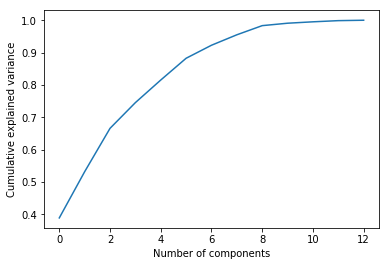

In [31]:
pca = PCA()
pca.fit(features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

## Validation

In [32]:
np.testing.assert_equal(features, computed_features[...,0:13])